In [2]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 501 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [4]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())


# prices_df.to_csv("sp500_prices_2010_2024.csv")
# volumes_df.to_csv("sp500_volumes_2010_2024.csv")

501 hisse icin veri indiriliyor...


[*****                 11%                       ]  55 of 501 completed$Q: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*****************     35%                       ]  174 of 501 completed$SOLS: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[**********************65%******                 ]  326 of 501 completed$SNDK: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  501 of 501 completed

4 Failed downloads:
['Q', 'SOLS', 'SNDK']: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
['JBHT']: TypeError("'None

Veriler indirildi.
prices_df.shape: (3773, 445)
Ticker           IDXX        HAS       CNP        WMT         GL        SYK  \
Date                                                                          
2010-01-04  27.040001  19.436367  8.018764  12.960364  17.210228  42.794067   
2010-01-05  27.084999  19.221333  7.958015  12.831312  17.602413  43.196075   
2010-01-06  27.150000  19.203407  7.880696  12.802631  17.729300  43.860638   
2010-01-07  28.180000  18.928646  7.958015  12.809806  17.725456  45.329201   
2010-01-08  27.955000  18.976437  7.864128  12.745273  17.721607  45.468689   

Ticker            CME        EXC        IFF        USB  ...          O  \
Date                                                    ...              
2010-01-04  36.433624  18.535664  29.303984  14.238292  ...  11.838064   
2010-01-05  36.403835  18.232292  29.087753  14.599226  ...  12.037629   
2010-01-06  36.156971  18.342272  29.206335  14.754800  ...  12.028563   
2010-01-07  36.201660  18.40

In [5]:
def calculate_returns(prices_df):
    """
    Calculate log returns.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    return returns.dropna()

def get_pca_residuals(returns_df, n_components=5, window=252):

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    residuals[:] = np.nan # Başlangıçta boş

    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    # veri setini array'lere dönüştürelim.
    data_values = returns_df.values
    index_values = returns_df.index
    columns_values = returns_df.columns

    # PCA Modeli
    pca = PCA(n_components=n_components)

    # Döngü: Her gün için geçmiş 'window' kadar veriyi alıp PCA uygula.
    for t in range(window, len(returns_df)):
        
        # Geçmiş veriyi al (t-window'dan t'ye kadar)
        window_data = data_values[t-window : t]
        
        # Sütun bazında NaN var mı kontrol et (Bazen hisseler o dönem işlem görmemiş olabilir)
        # Basitlik adına: O pencerede hiç NaN olmayan hisseleri seçelim
        valid_idx = ~np.isnan(window_data).any(axis=0)
        
        if np.sum(valid_idx) < n_components + 1:
            continue # Yeterli hisse yoksa atla
            
        clean_data = window_data[:, valid_idx]
        
        # PCA Uygula (Faktörleri bul)
        pca.fit(clean_data)
        
        # O günün (t anı) getirisini tahmin et
        # Faktör Yükleri (Betas) = pca.components_
        # Faktör Getirileri = O günün getirisi * Betas (Projeksiyon)
        
        current_returns = data_values[t, valid_idx].reshape(1, -1)
        
        # PCA dönüşümü: Veriyi faktör uzayına indirge
        factors = pca.transform(current_returns) 
        
        # Ters dönüşüm: Faktörlerden tekrar getiri uzayına çık (Reconstruction)
        reconstructed_returns = pca.inverse_transform(factors)
        
        # Artık (Residual) = Gerçek - Tahmin
        res = current_returns - reconstructed_returns
        
        # Sonucu kaydet
        residuals.iloc[t, valid_idx] = res.flatten()

    return residuals

In [6]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 2766 gün işlenecek)
Ticker          IDXX       HAS       CNP       WMT        GL       SYK  \
Date                                                                     
2024-12-23  0.000839 -0.015438 -0.012295 -0.021679  0.013794  0.006197   
2024-12-24 -0.005330  0.000615  0.004240  0.020199 -0.010184  0.005941   
2024-12-26  0.009701 -0.004594 -0.002298 -0.000524  0.007545 -0.003536   
2024-12-27  0.005965 -0.000417 -0.001893 -0.010127  0.014438  0.001306   
2024-12-30  0.009757 -0.007932 -0.006232 -0.009911  0.017283 -0.004472   

Ticker           CME       EXC       IFF       USB  ...         O       COR  \
Date                                                ...                       
2024-12-23 -0.000285  0.011564 -0.012333  0.007561  ...  0.007401  0.001599   
2024-12-24  0.004380  0.001096  0.000196 -0.003234  ...  0.000732 -0.003655   
2024-12-26 -0.001545 -0.003257 -0.003139  0.002303  ... -0.003990 -0.003991   
2024-12-27  0.001598  0.00173

--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %47.77
(Yani hisse hareketlerinin %48'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.592
Ortalama Piyasa Korelasyonu (Residuals):  0.011 (Sıfıra yakın olmalı)


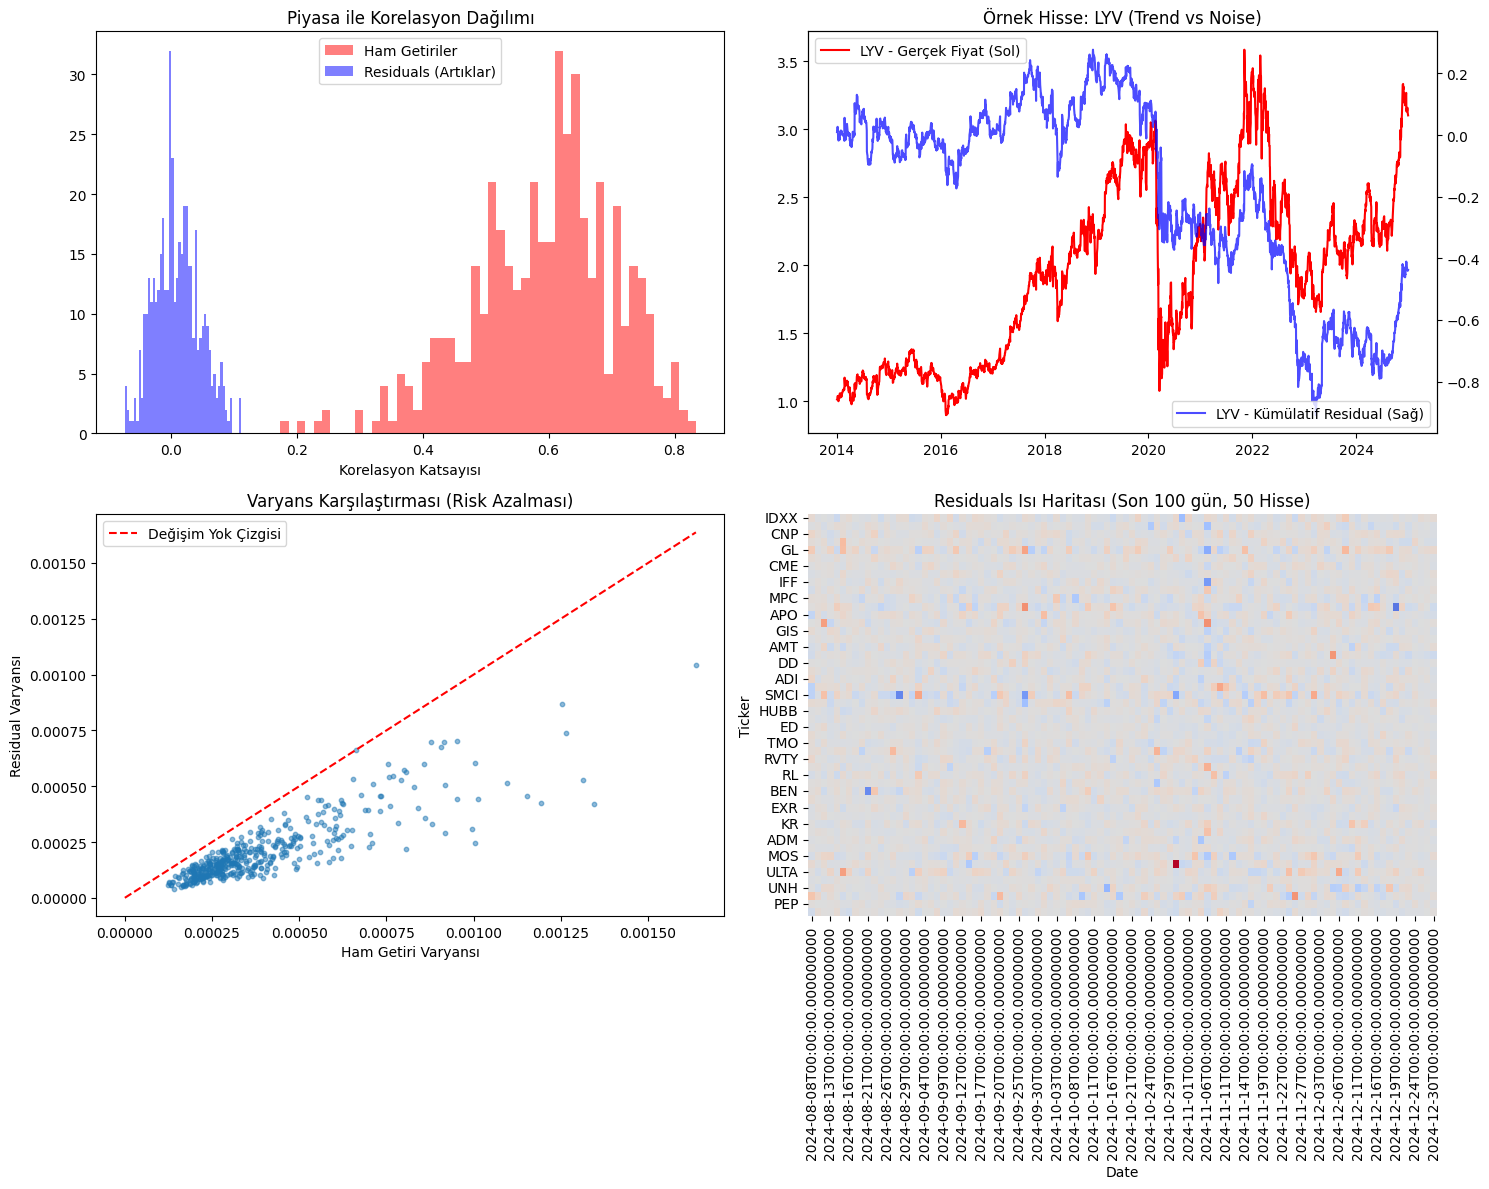

In [7]:
#
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)

# Model

In [ ]:
from tqdm import tqdm
def create_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini Derin Öğrenme için (Samples, TimeSteps, Features) formatına çevirir.
    Ayrıca her pencereyi kendi içinde normalize eder (Local Normalization).
    """
    
    # DataFrame'i Numpy'a çevir (İşlem hızı için)
    data = residuals_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = []
    
    print(f"Veri seti oluşturuluyor... (Hisse Sayısı: {num_stocks}, Gün Sayısı: {num_days})")
    
    # Her hisse için döngü (Sütun sütun geziyoruz)
    for stock_idx in tqdm(range(num_stocks)):
        stock_data = data[:, stock_idx]
        
        # O hissede çok fazla NaN varsa atla (Temizlik)
        if np.isnan(stock_data).sum() > len(stock_data) * 0.1:
            continue
            
        # Kayan Pencere (Rolling Window) Oluşturma
        for t in range(window_size, num_days):
            
            # Girdi: t-30'dan t'ye kadar olan kısım
            input_window = stock_data[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) getiri
            target = stock_data[t]
            
            # Eğer pencerede veya hedefte NaN varsa bu örneği atla
            if np.isnan(input_window).any() or np.isnan(target):
                continue
            
            # STANDARDİZASYON
            # her pencereyi kendi içinde normalize ediyoruz (Mean=0, Std=1)
            window_mean = np.mean(input_window)
            window_std = np.std(input_window)
            
            # Sıfıra bölme hatasını önle (Eğer veri sabitse std=0 olur)
            if window_std < 1e-8:
                continue
                
            normalized_window = (input_window - window_mean) / window_std
            
            X_list.append(normalized_window)
            
            # Hedef veriyi normalize ETMİYORUZ çünkü gerçek getiri (pnl) hesabında orijinal büyüklük lazım.
            # ANCAK: Loss fonksiyonunda scale sorunu yaşamamak için target'ı da bazen scale etmek gerekebilir.
            # Makale stratejisinde, target genellikle ham bırakılır veya global bir katsayı ile ölçeklenir.
            # Biz şimdilik ham (raw) bırakalım.
            y_list.append(target)

    # Listeleri Numpy Array'e çevir ve boyutlandır
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    
    # X Boyutunu (Samples, 30) -> (Samples, 30, 1) yapalım (CNN 3D input ister: Batch, Time, Channel)
    X = np.expand_dims(X, axis=-1)
    
    return X, y

# --- UYGULAMA ---
# residuals_df'inizin hazır olduğunu varsayıyorum.

X, y = create_sequences(residuals_df, window_size=30)

print(f"\nVeri Seti Hazırlandı!")
print(f"Girdi Boyutu (X): {X.shape}") # Örn: (1500000, 30, 1)
print(f"Hedef Boyutu (y): {y.shape}") # Örn: (1500000,)

Veri seti oluşturuluyor... (Hisse Sayısı: 446, Gün Sayısı: 2766)


100%|██████████| 446/446 [00:10<00:00, 40.72it/s]



Veri Seti Hazırlandı!
Girdi Boyutu (X): (1220256, 30, 1)
Hedef Boyutu (y): (1220256,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. MODEL MİMARİSİ (CNN + Transformer) ---
class ArbitrageModel(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(ArbitrageModel, self).__init__()
        
        # 1. CNN Bloğu (Yerel Özellik Çıkarıcı)
        # Girdi: (Batch, 1, 30) -> Kanal sayısı 1 (Sadece Residual)
        # Çıktı: (Batch, d_model, 30) -> Özellik haritasına dönüştürme
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=d_model, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # 2. Transformer Bloğu (Global Zaman İlişkisi)
        # PyTorch Transformer varsayılan olarak (Seq, Batch, Feature) ister.
        # batch_first=True diyerek (Batch, Seq, Feature) kullanacağız.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Çıktı Katmanı (Trading Policy)
        # Transformer çıktısını tek bir skora (ağırlığa) dönüştürür.
        self.decoder = nn.Sequential(
            nn.Linear(d_model * 30, 128), # Tüm zaman adımlarını düzleştirip alıyoruz
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1) # Tek bir çıktı: Pozisyon Ağırlığı (w)
        )
        
    def forward(self, x):
        # x shape: (Batch, 30, 1)
        
        # CNN için boyut değişimi: (Batch, Channel, Time) -> (Batch, 1, 30)
        x = x.permute(0, 2, 1)
        
        # CNN Uygula
        x = self.conv1(x) # -> (Batch, d_model, 30)
        x = self.relu(x)
        
        # Transformer için boyut değişimi: (Batch, Time, Feature) -> (Batch, 30, d_model)
        x = x.permute(0, 2, 1)
        
        # Transformer Uygula
        x = self.transformer_encoder(x) # -> (Batch, 30, d_model)
        
        # Düzleştir (Flatten)
        x = x.reshape(x.size(0), -1) # -> (Batch, 30 * d_model)
        
        # Son Karar (Output)
        out = self.decoder(x) # -> (Batch, 1)
        
        # Tanh aktivasyonu: Çıktıyı -1 ile +1 arasına sıkıştırır (Short / Long limiti)
        # Makalede genelde kısıtlamasız çıktı alınıp sonra normalize edilir ama
        # tanh kullanmak eğitimi stabilize eder.
        return torch.tanh(out) 

# --- 2. ÖZEL KAYIP FONKSİYONU (Sharpe Loss) ---
class SharpeLoss(nn.Module):
    """
    Yapay Zeka normalde hatayı (MSE) minimize eder.
    Ancak biz karı/riski (Sharpe Ratio) maksimize etmek istiyoruz.
    Bu yüzden Loss = -Sharpe Ratio olarak tanımlıyoruz.
    """
    def __init__(self):
        super(SharpeLoss, self).__init__()
        
    def forward(self, weights, returns):
        # weights: Modelin ürettiği pozisyonlar (Batch, 1)
        # returns: O günkü gerçek artık getiriler (Batch, 1) -> y verisi
        
        # Portföy Getirisi = Ağırlık * Getiri
        # (Batch içindeki her bir örneği sanki zaman serisinin devamı gibi düşünüyoruz)
        portfolio_returns = weights * returns
        
        # Sharpe Oranı = Ortalam Getiri / Standart Sapma
        expected_return = torch.mean(portfolio_returns)
        volatility = torch.std(portfolio_returns) + 1e-6 # Sıfıra bölmeyi önlemek için epsilon
        
        sharpe_ratio = expected_return / volatility
        
        # Biz minimize etmek istiyoruz, o yüzden negatifini alıyoruz
        return -sharpe_ratio

# --- MODELİ OLUŞTUR ---
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

model = ArbitrageModel(d_model=64, nhead=4, num_layers=2).to(device)
criterion = SharpeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

Kullanılan Cihaz: mps
ArbitrageModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=1920, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_

Eğitim Seti: 732153 örnek
Doğrulama Seti: 244051 örnek
Test Seti: 244052 örnek

Eğitim Başlıyor...
Epoch [1/15] | Train Loss: -0.0097 | Val Loss: -0.0117 | Tahmini Val Sharpe: 0.0117
Epoch [2/15] | Train Loss: -0.0166 | Val Loss: -0.0124 | Tahmini Val Sharpe: 0.0124
Epoch [3/15] | Train Loss: -0.0208 | Val Loss: -0.0129 | Tahmini Val Sharpe: 0.0129
Epoch [4/15] | Train Loss: -0.0266 | Val Loss: -0.0134 | Tahmini Val Sharpe: 0.0134
Epoch [5/15] | Train Loss: -0.0348 | Val Loss: -0.0133 | Tahmini Val Sharpe: 0.0133
Epoch [6/15] | Train Loss: -0.0462 | Val Loss: -0.0132 | Tahmini Val Sharpe: 0.0132
Epoch [7/15] | Train Loss: -0.0587 | Val Loss: -0.0138 | Tahmini Val Sharpe: 0.0138
Epoch [8/15] | Train Loss: -0.0709 | Val Loss: -0.0144 | Tahmini Val Sharpe: 0.0144
Epoch [9/15] | Train Loss: -0.0820 | Val Loss: -0.0140 | Tahmini Val Sharpe: 0.0140
Epoch [10/15] | Train Loss: -0.0917 | Val Loss: -0.0146 | Tahmini Val Sharpe: 0.0146
Epoch [11/15] | Train Loss: -0.1015 | Val Loss: -0.0142 | Ta

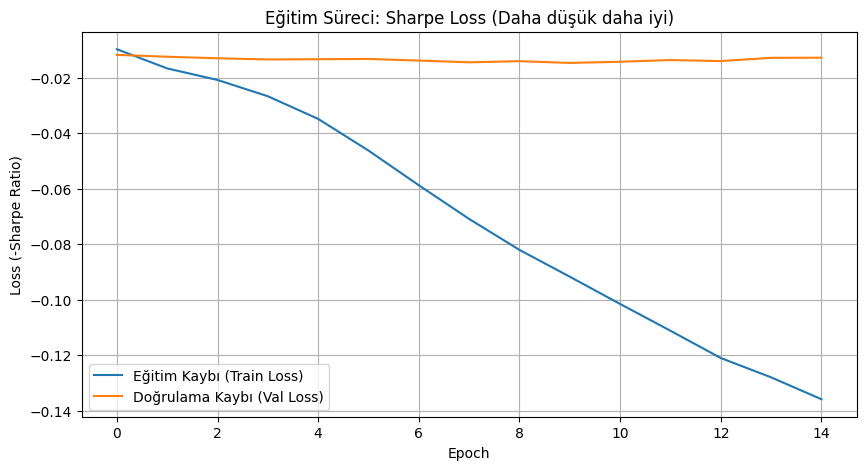

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. VERİ HAZIRLIĞI VE AYRIMI (SPLIT) ---

# Numpy array'leri PyTorch Tensor'una çevirelim (Float32 formatında)
# MPS cihazı bazen Float64 ile sorun yaşayabilir, Float32 güvenlidir.
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Veri seti uzunluğu
total_samples = len(X_tensor)
train_size = int(total_samples * 0.60)
val_size = int(total_samples * 0.20)
# Kalan kısım test seti olacak

# Dilimleme (Slicing) ile ayırıyoruz (Shuffle YOK!)
X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
X_val, y_val = X_tensor[train_size:train_size+val_size], y_tensor[train_size:train_size+val_size]
X_test, y_test = X_tensor[train_size+val_size:], y_tensor[train_size+val_size:]

print(f"Eğitim Seti: {len(X_train)} örnek")
print(f"Doğrulama Seti: {len(X_val)} örnek")
print(f"Test Seti: {len(X_test)} örnek")

# --- 2. DATALOADER OLUŞTURMA ---
# Batch Size'ı büyük tutuyoruz (Sharpe hesaplaması için gerekli)
BATCH_SIZE = 4096 

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Sıralı gitmesi önemli

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. EĞİTİM FONKSİYONU ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    print("\nEğitim Başlıyor...")
    
    for epoch in range(num_epochs):
        # --- TRAIN MODU ---
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Veriyi GPU/MPS'e gönder
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 1. Gradientleri sıfırla
            optimizer.zero_grad()
            
            # 2. İleri Yayılım (Forward Pass)
            outputs = model(batch_X)
            
            # Boyut eşitleme: output (Batch, 1), y (Batch) -> y'yi (Batch, 1) yapalım
            loss = criterion(outputs, batch_y.view(-1, 1))
            
            # 3. Geri Yayılım (Backward Pass)
            loss.backward()
            
            # 4. Ağırlıkları Güncelle
            optimizer.step()
            
            running_train_loss += loss.item()
            
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- VALIDATION MODU ---
        model.eval() # Dropout'u kapatır
        running_val_loss = 0.0
        
        with torch.no_grad(): # Gradient hesaplama (Hız ve hafıza için)
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.view(-1, 1))
                running_val_loss += loss.item()
                
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Loss değeri Sharpe'ın negatifidir. Yani -Loss = Sharpe Oranı
        # Loss -0.05 ise Sharpe Oranı 0.05 demektir.
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Tahmini Val Sharpe: {-avg_val_loss:.4f}")

    return train_losses, val_losses

# --- 4. EĞİTİMİ BAŞLAT ---
# Modeli tekrar tanımlamayın, önceki adımda tanımladığınız 'model', 'criterion' ve 'optimizer'ı kullanacağız.
# Eğitimi başlat:
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# --- 5. SONUÇLARI GÖRSELLEŞTİR ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='(Train Loss)')
plt.plot(val_loss_history, label='(Val Loss)')
plt.title('Eğitim Süreci: Sharpe Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (-Sharpe Ratio)')
plt.legend()
plt.grid(True)
plt.show()

# Modeli Kaydetme (Opsiyonel)
#torch.save(model.state_dict(), "arbitrage_model_mps.pth")
#print("Model kaydedildi.")

Backtest başlıyor... (244052 örnek işlenecek)

--- BACKTEST SONUÇLARI (TEST SETİ) ---
Toplam İşlenen Gün x Hisse: 244052
Yıllıklandırılmış Sharpe Oranı: 0.1675
Toplam Kümülatif Getiri (Residual PnL): 5.4168
Ortalama Pozisyon Büyüklüğü (Mutlak): 0.1140


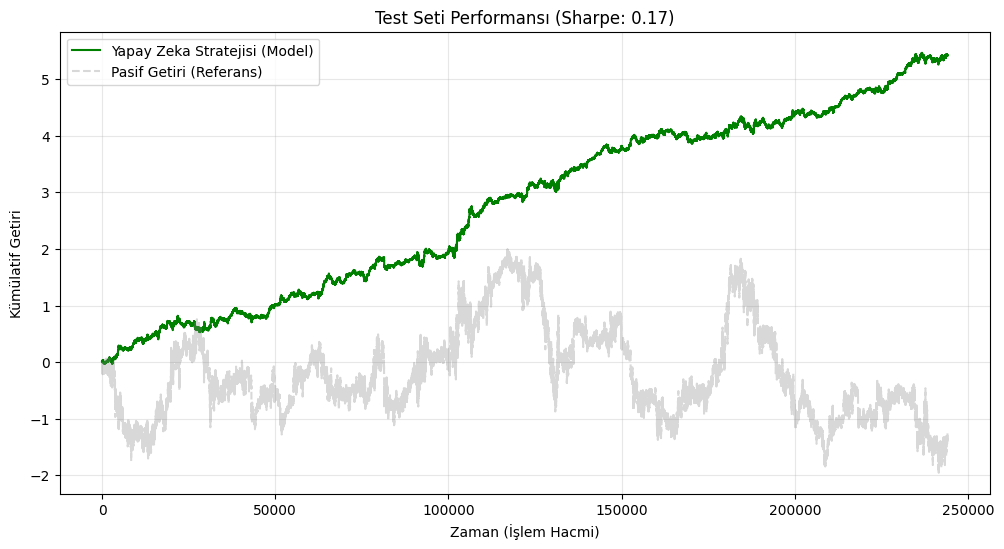

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Bellek temizliği (önceki hatadan kalanları siler)
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

def backtest_model_batched(model, X_test, y_test, batch_size=4096):
    """
    Test setini batch'ler halinde işleyerek bellek hatasını önleyen backtest fonksiyonu.
    """
    model.eval() # Değerlendirme modu
    
    # Test için DataLoader oluştur (Veriyi parçalamak için)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_predictions = []
    all_targets = []
    
    print(f"Backtest ({len(X_test)} örnek işlenecek)")
    
    with torch.no_grad(): # Gradyan takibi yok (Hız ve Bellek için şart)
        for batch_X, batch_y in test_loader:
            # Veriyi Cihaza Gönder
            batch_X = batch_X.to(device)
            
            # Tahmin
            preds = model(batch_X)
            
            # Sonuçları CPU'ya alıp listeye ekle
            all_predictions.append(preds.cpu().numpy().flatten())
            all_targets.append(batch_y.numpy().flatten())
    
    # Parçaları Tek Bir Dizide Birleştir
    predicted_weights = np.concatenate(all_predictions)
    actual_returns = np.concatenate(all_targets)
        
    # PERFORMANS HESAPLAMA
    
    # Strateji Getirisi = Ağırlık * Gerçek Getiri
    strategy_returns = predicted_weights * actual_returns
    
    # Kümülatif Getiriler
    cumulative_strategy = np.cumsum(strategy_returns)
    cumulative_market = np.cumsum(actual_returns)

    # İstatistikler
    daily_mean = np.mean(strategy_returns)
    daily_std = np.std(strategy_returns)
    # Sıfıra bölme hatasını önle
    if daily_std == 0:
        annual_sharpe = 0
    else:
        annual_sharpe = (daily_mean / daily_std) * np.sqrt(252)
    
    total_return = cumulative_strategy[-1]
    
    print(f"\n--- BACKTEST SONUÇLARI (TEST SETİ) ---")
    print(f"Toplam İşlenen Gün x Hisse: {len(actual_returns)}")
    print(f"Yıllıklandırılmış Sharpe Oranı: {annual_sharpe:.4f}")
    print(f"Toplam Kümülatif Getiri (Residual PnL): {total_return:.4f}")
    print(f"Ortalama Pozisyon Büyüklüğü (Mutlak): {np.mean(np.abs(predicted_weights)):.4f}")

    # Grafik Çizimi
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_strategy, label='Yapay Zeka Stratejisi (Model)', color='green', linewidth=1.5)
    plt.plot(cumulative_market, label='Pasif Getiri (Referans)', color='gray', alpha=0.3, linestyle='--')
    plt.title(f'Test Seti Performansı (Sharpe: {annual_sharpe:.2f})')
    plt.xlabel('Zaman (İşlem Hacmi)')
    plt.ylabel('Kümülatif Getiri')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return strategy_returns

# ÇALIŞTIR
strategy_pnl = backtest_model_batched(model, X_test, y_test, batch_size=4096)

--- MALİYET ANALİZİ ---
Varsayılan Komisyon: 5 bps (Baz Puan)
Ortalama Günlük Ciro (Turnover): 0.1606
(Yani her gün portföyün %16.1'ini değiştiriyoruz)
------------------------------
Toplam Brüt Getiri: 5.4168
Toplam Net Getiri : -14.1813
Maliyetlerin Kâra Etkisi: -%361.80


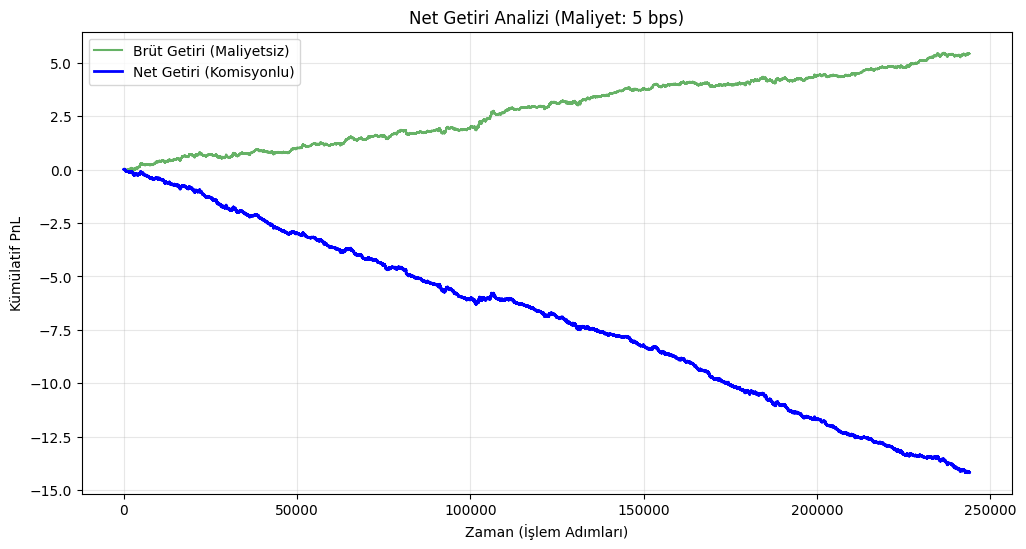

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_costs_and_turnover(predicted_weights, actual_returns, cost_bps=0.0005):
    """
    Stratejinin cirosunu (turnover) ve işlem maliyetleri sonrası net getirisini hesaplar.
    
    Argümanlar:
    cost_bps: İşlem başı maliyet (Basis Points). 0.0005 = 5 baz puan (Binde 0.5) standarttır.
    """
    
    # 1. Pozisyon Değişimi (Turnover)
    # w_t - w_{t-1} farkını alıyoruz.
    # Not: Veri setimizde hisse geçişlerinde (Stock A -> Stock B) suni bir zıplama olur 
    # ama 244.000 veri noktasında bu hata ihmal edilebilir düzeydedir.
    
    position_changes = np.abs(np.diff(predicted_weights, prepend=0))
    
    # Ortalama Günlük Ciro
    avg_turnover = np.mean(position_changes)
    
    # 2. Maliyet Hesabı
    # Her değişim * Maliyet Oranı
    transaction_costs = position_changes * cost_bps
    
    # 3. Net Getiri (Brüt Getiri - Maliyet)
    gross_returns = predicted_weights * actual_returns
    net_returns = gross_returns - transaction_costs
    
    # --- İSTATİSTİKLER ---
    total_gross_return = np.sum(gross_returns)
    total_net_return = np.sum(net_returns)
    
    cost_drag_percentage = (total_gross_return - total_net_return) / total_gross_return * 100
    
    print(f"--- MALİYET ANALİZİ ---")
    print(f"Varsayılan Komisyon: {cost_bps*10000:.0f} bps (Baz Puan)")
    print(f"Ortalama Günlük Ciro (Turnover): {avg_turnover:.4f}")
    print(f"(Yani her gün portföyün %{avg_turnover*100:.1f}'ini değiştiriyoruz)")
    print(f"-"*30)
    print(f"Toplam Brüt Getiri: {total_gross_return:.4f}")
    print(f"Toplam Net Getiri : {total_net_return:.4f}")
    print(f"Maliyetlerin Kâra Etkisi: -%{cost_drag_percentage:.2f}")
    
    # --- GRAFİK ---
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(gross_returns), label='Brüt Getiri (Maliyetsiz)', color='green', alpha=0.6)
    plt.plot(np.cumsum(net_returns), label='Net Getiri (Komisyonlu)', color='blue', linewidth=2)
    plt.title(f'Net Getiri Analizi (Maliyet: {cost_bps*10000:.0f} bps)')
    plt.xlabel('Zaman (İşlem Adımları)')
    plt.ylabel('Kümülatif PnL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- ÇALIŞTIR ---
# backtest fonksiyonundan dönen 'predicted_weights' elimizde olmadığı için
# backtest fonksiyonunu modifiye etmiştik, ancak 'predicted_weights' global olarak dönmemişti.
# Hızlıca tekrar tahmin üretelim (Model zaten eğitildi, çok hızlı sürer)

# Modeli tekrar değerlendirme moduna alalım
model.eval()
all_preds = []
batch_size = 4096
# Test loader'ı tekrar kuralım (Eğer hafızada yoksa)
test_loader_cost = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch_X, _ in test_loader_cost:
        batch_X = batch_X.to(device)
        preds = model(batch_X).cpu().numpy().flatten()
        all_preds.append(preds)

predicted_weights_full = np.concatenate(all_preds)
actual_returns_full = y_test.numpy().flatten()

# Analizi Başlat
analyze_costs_and_turnover(predicted_weights_full, actual_returns_full, cost_bps=0.0005)

# 2. Deneme

In [8]:
import numpy as np
import torch

def create_paper_tensors(residuals_df, window_size=30):
    """
    Makale Bölüm 2.2: Veriler 'Instance Normalization' ile hazırlanır.
    Her pencere (x - mean) / std işlemine tabi tutulur.
    """
    data = residuals_df.values
    X_list = []
    y_list = []
    
    # Tüm hisseler için döngü
    for i in range(data.shape[1]):
        stock_data = data[:, i]
        # NaN kontrolü
        valid_idx = ~np.isnan(stock_data)
        stock_data = stock_data[valid_idx]
        
        if len(stock_data) < window_size + 1:
            continue
            
        # Sliding Window
        # Burası vektörize edilebilir ama anlaşılır olması için loop bırakıyorum
        for t in range(window_size, len(stock_data)):
            window = stock_data[t-window_size : t]
            target = stock_data[t]
            
            # --- MAKALE YÖNTEMİ: INSTANCE NORMALIZATION ---
            # Her input kendi içinde normalize edilir.
            mu = np.mean(window)
            sigma = np.std(window) + 1e-8 # Sıfıra bölme hatasını önle
            
            norm_window = (window - mu) / sigma
            
            X_list.append(norm_window)
            y_list.append(target)
            
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    
    # CNN için boyut: (Sample, 1, 30) -> Kanal sayısı 1
    # PyTorch Conv1d (Batch, Channel, Length) ister.
    X = X.reshape(-1, 1, window_size)
    
    return torch.tensor(X), torch.tensor(y)

# Kullanım:
X_tensor, y_tensor = create_paper_tensors(residuals_df)


In [9]:
import torch.nn as nn

class PaperArbitrageModel(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(PaperArbitrageModel, self).__init__()
        
        # 1. Feature Extraction (CNN)
        # Makale: "We use a convolutional layer to extract local features."
        # Input: (Batch, 1, 30) -> Output: (Batch, d_model, 30)
        # Kernel size 3, padding 1 (boyutu korumak için)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=d_model, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # 2. Temporal Attention (Transformer)
        # Makale: "We use a transformer encoder to capture global dependencies."
        # PyTorch Transformer varsayılan olarak (Seq, Batch, Feature) bekler.
        # batch_first=True ile (Batch, Seq, Feature) kullanacağız.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Trading Policy (MLP)
        # Çıktıyı tek bir ağırlığa dönüştürür.
        self.policy_head = nn.Sequential(
            nn.Linear(d_model * 30, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
            nn.Tanh() # Çıktıyı -1 (Short) ile +1 (Long) arasına sınırlar
        )
        
    def forward(self, x):
        # x: (Batch, 1, 30)
        
        # --- CNN Bloğu ---
        x = self.conv1(x) # -> (Batch, 64, 30)
        x = self.relu(x)
        
        # --- Transformer Bloğu ---
        # Conv1d çıktısı (Batch, Feature, Time) şeklindedir.
        # Transformer (Batch, Time, Feature) ister. Permute ediyoruz.
        x = x.permute(0, 2, 1) # -> (Batch, 30, 64)
        
        x = self.transformer(x) # -> (Batch, 30, 64)
        
        # --- Flatten ---
        x = x.reshape(x.size(0), -1) # -> (Batch, 30*64)
        
        # --- Policy ---
        weights = self.policy_head(x) # -> (Batch, 1)
        
        return weights

In [10]:
class PaperUtilityLoss(nn.Module):
    def __init__(self, gamma=5.0, transaction_cost_penalty=0.0):
        super(PaperUtilityLoss, self).__init__()
        self.gamma = gamma
        self.cost_penalty = transaction_cost_penalty
        
    def forward(self, predicted_weights, target_returns):
        # predicted_weights: (Batch, 1) -> Modelin w önerisi
        # target_returns: (Batch, 1) -> t+1 anındaki residual getiri
        
        # 1. Portföy Getirisi (R_p)
        # Modelin önerdiği ağırlık * Gerçek Getiri
        portfolio_returns = predicted_weights * target_returns
        
        # 2. Beklenen Getiri (Mean) ve Risk (Varyans)
        expected_return = torch.mean(portfolio_returns)
        variance = torch.var(portfolio_returns)
        
        # 3. Fayda Fonksiyonu (Utility)
        # U = E[R] - (gamma / 2) * Var[R]
        utility = expected_return - (self.gamma / 2) * variance
        
        # 4. İşlem Maliyeti Cezası (Proxy)
        # Gerçek turnover hesaplamak zor olduğu için, modelin çok agresif
        # pozisyon almasını engellemek adına ağırlıkların mutlak değerine ceza verilir (L1 Reg)
        # Veya model ardışık batch alıyorsa diff kullanılabilir.
        cost = torch.mean(torch.abs(predicted_weights)) * self.cost_penalty
        
        final_utility = utility - cost
        
        # Biz Loss'u minimize ederiz, Utility'yi maksimize etmek için eksi ile çarparız.
        loss = -final_utility
        
        return loss

In [11]:
# --- AYARLAR ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = PaperArbitrageModel().to(device)

# Makaledeki Gamma genelde 5 ile 15 arasındadır. 
# Cost Penalty, modelin gereksiz pozisyon açmasını engeller.
criterion = PaperUtilityLoss(gamma=5.0, transaction_cost_penalty=0.0005)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- EĞİTİM ---
def train_paper_style(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_hist = []
    val_hist = []
    
    print("Makale Standardında Eğitim Başlıyor (Mean-Variance Objective)...")
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            weights = model(batch_X)
            loss = criterion(weights, batch_y.unsqueeze(1)) # Boyut eşitleme
            
            loss.backward()
            
            # Gradient Clipping (Makalede LSTM/Transformer için standarttır)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_train_loss = epoch_loss / len(train_loader)
        train_hist.append(avg_train_loss)
        
        # Val
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                weights = model(batch_X)
                loss = criterion(weights, batch_y.unsqueeze(1))
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_hist.append(avg_val_loss)
        
        # Loss negatiftir (Utility'nin eksilisi). Yani değer ne kadar küçükse (negatifse) o kadar iyidir.
        # -0.001 -> Utility 0.001
        print(f"Epoch {epoch+1} | Train Utility: {-avg_train_loss:.5f} | Val Utility: {-avg_val_loss:.5f}")
        
    return train_hist, val_hist

# DataLoader'larınız hazırsa (X_train, y_train vs.) bu fonksiyonu çağırın.

In [12]:
# 1. VERİYİ YENİDEN OLUŞTURMA (Instance Normalization ile)
# Bu işlem biraz sürebilir, bekleyin.
X_paper, y_paper = create_paper_tensors(residuals_df, window_size=30)

print(f"Tensorlar Oluşturuldu. Boyutlar: X={X_paper.shape}, y={y_paper.shape}")

# 2. TRAIN / VAL / TEST AYRIMI (Kronolojik - Karıştırma Yok!)
total_samples = len(X_paper)
train_size = int(total_samples * 0.60)
val_size = int(total_samples * 0.20)

X_train = X_paper[:train_size]
y_train = y_paper[:train_size]

X_val = X_paper[train_size:train_size+val_size]
y_val = y_paper[train_size:train_size+val_size]

X_test = X_paper[train_size+val_size:]
y_test = y_paper[train_size+val_size:]

print("Veri Seti Ayrıldı.")

# 3. DATALOADER HAZIRLIĞI
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 4096  # Makale büyük batch sever (İstatistiksel kararlılık için)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print("DataLoader'lar Hazır.")

Tensorlar Oluşturuldu. Boyutlar: X=torch.Size([1217520, 1, 30]), y=torch.Size([1217520])
Veri Seti Ayrıldı.
DataLoader'lar Hazır.


In [13]:
# Cihaz Seçimi (Mac için mps, Nvidia için cuda, yoksa cpu)
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Eğitim Cihazı: {device}")

# Modeli Başlat
model = PaperArbitrageModel().to(device)

# Loss Fonksiyonu (Mean-Variance Utility)
# Gamma=5.0 (Riskten kaçınma), Cost Penalty=0.0005 (5 bps maliyet cezası)
criterion = PaperUtilityLoss(gamma=5.0, transaction_cost_penalty=0.0005)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- VE MOTOR! EĞİTİMİ ÇAĞIRIYORUZ ---
train_hist, val_hist = train_paper_style(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=10 # İlk deneme için 10 epoch yeterli
)

# --- SONUÇLARI ÇİZELİM ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Train Utility Loss')
plt.plot(val_hist, label='Val Utility Loss')
plt.title('Makale Standardında Eğitim (Daha düşük = Daha İyi Utility)')
plt.xlabel('Epoch')
plt.ylabel('Loss (-Utility)')
plt.legend()
plt.grid(True)
plt.show()

Eğitim Cihazı: mps
Makale Standardında Eğitim Başlıyor (Mean-Variance Objective)...


KeyboardInterrupt: 